In [1]:
import uproot
import awkward

import numpy as np
from matplotlib import pyplot as plt

from pprint import pprint

import os

In [2]:
file_dir = '../data/base/Ntuple_runsampic_166_runtelescope_643.root'
file = uproot.open(file_dir)

file.keys()

['desy;24', 'desy;23']

# Contents of the file

In [3]:
file_events = file['desy;23']
file_events.show()
print(file_events.keys())

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
RunSampic            | int32_t                  | AsDtype('>i4')
RunTelescope         | int32_t                  | AsDtype('>i4')
eventIDTelescope     | int32_t                  | AsDtype('>i4')
nTrackParams         | int32_t                  | AsDtype('>i4')
planeID              | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
trackID              | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
triggerID            | int32_t                  | AsDtype('>i4')
timestamp            | int32_t                  | AsDtype('>i4')
xPos                 | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
yPos                 | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
omega                | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
phi                  | std::vector<double> 

# Extract needed data

In [4]:
FILE_KEY = 'desy;23'
EVENT_KEYS = set(['num_samples', 'eventIDSampic', 'sample_time', 'sample_ampl', 'sample_channel'])

In [5]:
def extract_filtered_data(file_events, event_keys=EVENT_KEYS):
    mask = file_events['num_samples'].array()[:10000] > 0
    events_filtered = {k: file_events[k].array()[:10000][mask] for k in event_keys}
    return events_filtered

In [6]:
file_events = file[FILE_KEY]
events_filtered = extract_filtered_data(file_events)

In [25]:
events_filtered

{'num_samples': <Array [4, 2, 3, 2, 2, 3, ... 3, 2, 4, 3, 2, 1] type='3227 * uint32'>,
 'sample_channel': <Array [[29, 11, 16, 23], ... [22, 10], [0]] type='3227 * var * int32'>,
 'sample_time': <Array [[[0, 1.56e-10, ... 9.84e-09]]] type='3227 * var * 64 * float64'>,
 'sample_ampl': <Array [[[1.03, 1.03, 1.03, ... 1.05, 1.05]]] type='3227 * var * 64 * float64'>,
 'eventIDSampic': <Array [4361, 4368, 4373, ... 14659, 14661] type='3227 * uint32'>}

In [7]:
file_name = os.path.split(file_dir)[1]
print(f'Processing {file_name} ...')

with uproot.recreate(f'../data/{file_name}') as new_file:
    new_file['tree_data'] = events_filtered

Processing Ntuple_runsampic_166_runtelescope_643.root ...


# Read the new file

In [26]:
new_file = uproot.open(f'../data/{file_name}')
new_file['tree_data'].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
num_samples          | uint32_t                 | AsDtype('>u4')
nsample_channel      | int32_t                  | AsDtype('>i4')
sample_channel       | int32_t[]                | AsJagged(AsDtype('>i4'))
nsample_time         | int32_t                  | AsDtype('>i4')
sample_time          | double[][64]             | AsJagged(AsDtype("('>f8', (...
nsample_ampl         | int32_t                  | AsDtype('>i4')
sample_ampl          | double[][64]             | AsJagged(AsDtype("('>f8', (...
eventIDSampic        | uint32_t                 | AsDtype('>u4')


In [27]:
new_file['tree_data']['sample_time'].array()

ValueError: basket 0 in tree/branch /tree_data;1:sample_time has the wrong number of bytes (64368) for interpretation AsDtype("('>f8', (64,))")
in file ../data/Ntuple_runsampic_166_runtelescope_643.root

# Example samples

In [9]:
def plot_sample(events, i_event, i_sample, use_time=False, flip=True):
    if use_time:
        X = events['sample_time'][i_event][i_sample]
    else:
        X = np.arange(64)
    Y = events['sample_ampl'][i_event][i_sample]
    if flip:
        Y = (Y - 1) * -1
    plt.plot(X, Y)
#     plt.title(f"sampic event id: {events_filtered['eventIDSampic']}, ({i_event}, {i_sample})")
    plt.title(f'({i_event}, {i_sample})')
    plt.ylim(-0.1, 1.1)

IndexError: list index out of range

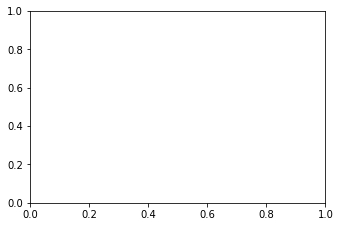

In [10]:
events = [0, 0, 0, 1003, 1003, 1003, 3006, 3006, 3006]
samples = [0, 1, 2, 0, 1, 2, 0, 1, 2]

plt.figure(figsize=(18, 12))
for i, (i_event, i_sample) in enumerate(zip(events, samples)):
    plt.subplot(3, 3, i + 1)
    plot_sample(new_events, i_event, i_sample)